# Do Timestamps Match up?

In [14]:
import imp
import run_analysis as ana
from ximea import xiapi
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

import ximea_cam_aquire_save as xim

from time import sleep, time
import pupil_cam_aquire_save as pup
import zmq_socket as zmqs
#import pupil.pupil_src.shared_modules.file_methods as pupfm
import threading

## Collect some Images from Eyetracker & Ximea Cameras

***Dont Actually Do this unless you want to spend a bunch of time to go through and find the blinking on and off**

Collect with all 4 cameras (2 ximea, 2 pupil labs) facing a strobing light to determine if on/off times are matched.

In [15]:
collection_mins = 1
save_batchsize = 200
pupil_port = 50020 #42715
ncameras = 2

pupil_save_dir_name = '/home/vasha/code/backpack_computer_aquisition/test_timestamps/pupil'
ximea_save_folder_list = ['./test_timestamps_near', '/tb_disk/test_timestamps_near']
analysis_folder = './test_timestamps/analysis_near'
if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)

#Don't actually recapture
recapture=True

In [16]:
if(recapture):
    #start pupil labs aquisition as a spun off thread
    eyetracker_thread = threading.Thread(target=pup.run_pupillabs_aquisition, 
                                            args=(pupil_save_dir_name,
                                                 collection_mins,
                                                 pupil_port))
    eyetracker_thread.daemon = True  # Daemonize threadse
    eyetracker_thread.start()        # Start the execution   

    #run ximea acquision realtime.
    xim.ximea_acquire(ximea_save_folder_list, max_collection_mins=collection_mins, ims_per_file=save_batchsize, num_cameras=ncameras)
else:
    print("Not Actually Recapturing. Assume we already have data")

PUPIL_CAM Connecting to socket at 127.0.0.1:50020 ...
Timesync successful.
SCENE_CAM Starting Acquisition threads...
SCENE_CAM Opening Camera odPUPIL_CAM Beginning Recording for max 1 mins...

/home/vasha/code/backpack_computer_aquisition/test_timestamps/pupil
SCENE_CAM Opening Camera cy
SCENE_CAM Recording Timestamp Syncronization Pre...
SCENE_CAM Recording Timestamp Syncronization Pre...
SCENE_CAM Begin Recording for up to 12000 frames...
SCENE_CAM Begin Recording for up to 12000 frames...
SCENE_CAM Detected Keyboard Interrupt (main thread). Stopping Camera Acquisition
SCENE_CAM All Finished - Ending Ximea Camera Now.
SCENE_CAM Reached 12000 frames collectedSCENE_CAM Reached 12000 frames collected

SCENE_CAM Camera cy Cleanup...SCENE_CAM Camera od Cleanup...

SCENE_CAM Camera od aquisition finished
SCENE_CAM Camera cy aquisition finished
You Pressed s!


Exception in thread Thread-26:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/vasha/code/backpack_computer_aquisition/pupil_cam_aquire_save.py", line 51, in run_pupillabs_aquisition
    socket.stop_recording()
  File "/home/vasha/code/backpack_computer_aquisition/zmq_socket.py", line 79, in stop_recording
    return self.socket.recv_string()
  File "/home/vasha/.local/lib/python3.6/site-packages/zmq/sugar/socket.py", line 592, in recv_string
    msg = self.recv(flags=flags)
  File "zmq/backend/cython/socket.pyx", line 791, in zmq.backend.cython.socket.Socket.recv
  File "zmq/backend/cython/socket.pyx", line 827, in zmq.backend.cython.socket.Socket.recv
  File "zmq/backend/cython/socket.pyx", line 191, in zmq.backend.cython.socket._recv_copy
  File "zmq/backend/cython/socket.pyx", line 186, in zm

## Paths for Timestamps Files

In [7]:
od_ximea_timestamp_path = os.path.join(ximea_save_folder_list[0],'timestamps_od.tsv')
cy_ximea_timestamp_path = os.path.join(ximea_save_folder_list[1],'timestamps_cy.tsv')

od_ximea_timesync_path = os.path.join(ximea_save_folder_list[0],'timestamp_camsync_od.tsv')
cy_ximea_timesync_path = os.path.join(ximea_save_folder_list[1],'timestamp_camsync_cy.tsv')

#od_pupil_timestamp_path = os.path.join(pupil_save_dir_name,'000','eye0_timestamps.npy')
#os_pupil_timestamp_path = os.path.join(pupil_save_dir_name,'000','eye1_timestamps.npy')


## Convert to unified wall clock time

In [8]:
imp.reload(ana)
od_ximea_timestamps = ana.convert_ximea_time_to_unix_time(od_ximea_timestamp_path, od_ximea_timesync_path)
cy_ximea_timestamps = ana.convert_ximea_time_to_unix_time(cy_ximea_timestamp_path, cy_ximea_timesync_path)

od_ximea_timestamp_converted_path = os.path.join(analysis_folder,'timestamps_converted_od.tsv')
cy_ximea_timestamp_converted_path = os.path.join(analysis_folder,'timestamps_converted_cy.tsv')

np.savetxt(od_ximea_timestamp_converted_path, od_ximea_timestamps, fmt='%10.5f', delimiter='\t')
np.savetxt(cy_ximea_timestamp_converted_path, cy_ximea_timestamps, fmt='%10.5f', delimiter='\t')

Time Elapsed: 82.13241648674011 seconds
Time Drift pre to post: 0.010135617259834362 seconds
Time Elapsed: 81.57775068283081 seconds
Time Drift pre to post: 0.011465701169186104 seconds


## Find Image of Two Ximea Cameras near Turn-on Point

In [9]:
imp.reload(ana)
target_timestamp = 1573612041.035

frame_od, ts_od = ana.ximea_timestamp_to_framenum(od_ximea_timestamp_converted_path, target_timestamp)
frame_cy, ts_cy = ana.ximea_timestamp_to_framenum(cy_ximea_timestamp_converted_path, target_timestamp)
#ts_cy = ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy) #reverse


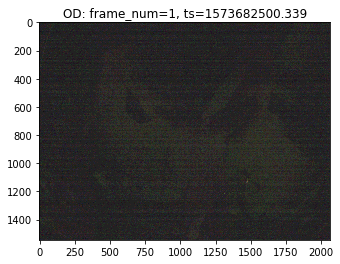

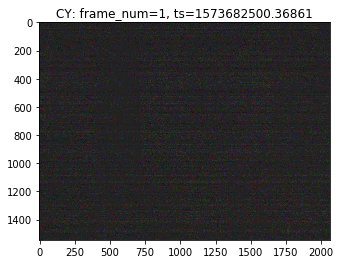

In [13]:
img_od = ana.ximea_get_frame(frame_od, save_batchsize, 'od', ximea_save_folder_list[0])
img_cy = ana.ximea_get_frame(frame_cy, save_batchsize, 'cy', ximea_save_folder_list[1])

plt.imshow(img_od)
plt.title(f'OD: frame_num={frame_od}, ts={ts_od}')
plt.show()
plt.imshow(img_cy)
plt.title(f'CY: frame_num={frame_cy}, ts={ts_cy}')
plt.show()

## Turn On - OD

NameError: name 'od_timestamp_path' is not defined

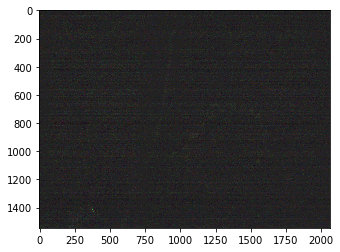

In [9]:
imp.reload(ana)
img_od = ana.ximea_get_frame(frame_od-1, save_batchsize, 'od', ximea_save_folder_list[0])
plt.imshow(img_od)
plt.title(f'OD: frame_num={frame_od-1}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od-1)}')
plt.show()

img_od = ana.ximea_get_frame(frame_od, save_batchsize, 'od', ximea_save_folder_list[0])
plt.imshow(img_od)
plt.title(f'OD: frame_num={frame_od}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od)}')
plt.show()

img_od = ana.ximea_get_frame(frame_od+1, save_batchsize, 'od', ximea_save_folder_list[0])
plt.imshow(img_od)
plt.title(f'OD: frame_num={frame_od+1}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od+1)}')
plt.show()

## Turn On - OS

In [ ]:
imp.reload(ana)
img_od = ana.ximea_get_frame(frame_cy-1, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy-1}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy-1)}')
plt.show()

img_od = ana.ximea_get_frame(frame_cy, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy)}')
plt.show()

img_od = ana.ximea_get_frame(frame_cy+1, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy+1}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy+1)}')
plt.show()

## Find Image of Two Ximea Cameras near Turn-off Point

In [ ]:
imp.reload(ana)
target_timestamp = 5837.48

frame_od, ts_od = ana.ximea_timestamp_to_framenum(od_timestamp_path, target_timestamp)
frame_cy, ts_cy = ana.ximea_timestamp_to_framenum(cy_timestamp_path, target_timestamp)
#ts_cy = ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy) #reverse

img_od = ana.ximea_get_frame(frame_od, save_batchsize, 'od', ximea_save_folder_list[0])
img_cy = ana.ximea_get_frame(frame_cy, save_batchsize, 'cy', ximea_save_folder_list[1])

In [ ]:
plt.imshow(img_od)
plt.title(f'OD: frame_num={frame_od}, ts={ts_od}')
plt.show()
plt.imshow(img_cy)
plt.title(f'CY: frame_num={frame_cy}, ts={ts_cy}')
plt.show()

## Turn Off - OD

In [ ]:
imp.reload(ana)
img_od = ana.ximea_get_frame(frame_od-1, save_batchsize, 'od', ximea_save_folder_list[0])
plt.imshow(img_od)
plt.title(f'OD: frame_num={frame_od-1}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od-1)}')
plt.show()

img_od = ana.ximea_get_frame(frame_od, save_batchsize, 'od', ximea_save_folder_list[0])
plt.imshow(img_od)
plt.title(f'OD: frame_num={frame_od}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od)}')
plt.show()

img_od = ana.ximea_get_frame(frame_od+1, save_batchsize, 'od', ximea_save_folder_list[0])
plt.imshow(img_od)
plt.title(f'OD: frame_num={frame_od+1}, ts={ana.ximea_framenum_to_timestamp(od_timestamp_path, frame_od+1)}')
plt.show()

## Turn Off - CY

In [ ]:
imp.reload(ana)
img_od = ana.ximea_get_frame(frame_cy-1, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy-1}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy-1)}')
plt.show()

img_od = ana.ximea_get_frame(frame_cy, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy)}')
plt.show()

img_od = ana.ximea_get_frame(frame_cy+1, save_batchsize, 'cy', ximea_save_folder_list[1])
plt.imshow(img_od)
plt.title(f'CY: frame_num={frame_cy+1}, ts={ana.ximea_framenum_to_timestamp(cy_timestamp_path, frame_cy+1)}')
plt.show()

## Turn Off - Pupil Labs Eye 1

The light turns off between:   
OD: 5837.478 and 5837.483   
CY: 5837.478 and 5837.483   

Timestamps are syncing up - this seems a bit unexpected. Checking manually it looks like the only happens some of the time. I wonder if it may have something to do with the bandwidth being limited.  

In [ ]:
imp.reload(ana)
ana.pupil_framenum_to_timestamp(od_pupil_timestamp_path, 120)

In [ ]:
pupil_timestamp_to_framenum(od_pupil_timestamp_path, target_timestamp)

In [ ]:
ts = np.load(od_pupil_timestamp_path)

In [ ]:
ts.shape

In [ ]:
ts[:10]